# Import Modules

In [1]:
import torch
import os

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from abc import abstractmethod

import math

import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from torchvision import datasets, transforms, utils, models
from torchvision.utils import save_image, make_grid
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, Subset
from torch.utils import data


from diffusion_inference import *
from interpolations import *
from inference_modules import *

# Load Data from LabeledDataset

In [3]:
data_dir = '/home/hcn98/[MICCAI2025]SIDM/LabeledDataset/'
labeled_classes = list_image_files_recursively(os.path.join(data_dir, 'labeled_masks'), key = extract_number)

# Load Pre-Trained SIDM model

In [ ]:
unet = create_model(
        args.image_size, 
        args.num_classes,
        args.num_channels,
        num_labels, 
        args.num_res_blocks, 
        channel_mult=args.channel_mult, 
        learn_sigma=args.learn_sigma, 
        class_cond=args.class_cond, 
        use_checkpoint=args.use_checkpoint, 
        attention_resolutions=args.attention_resolutions,
        num_heads=args.num_heads,
        num_head_channels=args.num_head_channels,
        num_heads_upsample=args.num_heads_upsample,
        use_scale_shift_norm=args.use_scale_shift_norm,
        dropout=args.dropout,
        resblock_updown=args.resblock_updown,
        use_fp16=args.use_fp16,
        use_new_attention_order=args.use_new_attention_order,
        no_instance=args.no_instance,
    )

# Initialize pre-trained diffusion model and optimizer
diffusion = Diffusion(nn_model=unet, betas=(args.beta1, args.beta2), n_T=args.n_T, device=device, drop_prob=args.dp)
optim = torch.optim.Adam(diffusion.parameters(), lr=args.lrate)

# Load checkpoint
save_dir = args.save_dir
checkpoint = torch.load(save_dir+f' ', map_location=device)  #your trained model!
diffusion.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

# Inference

In [4]:
def inference(idx1, idx2,interpol_step):
    mask1 = process_directory_fortestmask(labeled_classes[idx1-1])
    mask2 = process_directory_fortestmask(labeled_classes[idx2-1])
    interpolated_masks = interp_shape(mask1, mask2, interpol_step)
    test_masks = interpolated_mask_preprocess(interpolated_masks)
    test_label = interpolate_class_pytorch(int(re.findall(r'\d+', labeled_classes[idx1-1])[-1]),int(re.findall(r'\d+', labeled_classes[idx2-1])[-1]),930,interpol_step)

    diffusion.eval()
    test_image = []
    with torch.no_grad():
        n_sample = 1
        for i in range(len(test_masks)):
            mask_cond = test_masks[i].unsqueeze(0)   
            label_cond = test_label[i].unsqueeze(0) 

            mask_cond = mask_cond.clone().detach()
            label_cond = label_cond.clone().detach()

            x_gen = diffusion.sample(n_sample, (3,256,256), device, condition=[mask_cond, label_cond] , guide_w=1.5) 
            x_gen = (x_gen + 1) / 2
            x_gen = x_gen.clamp(0,1)
            img = x_gen[0].cpu().numpy().transpose(1,2,0).squeeze()
            test_image.append(img)

    visualize_masks_and_images(test_masks, np.array(test_image))

/home/hcn98/[MICCAI2025]SIDM/diffusion_inference.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_cond = torch.tensor(mask_cond)
/home/hcn98/[MICCAI2025]SIDM/diffusion_inference.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_cond = torch.tensor(label_cond)


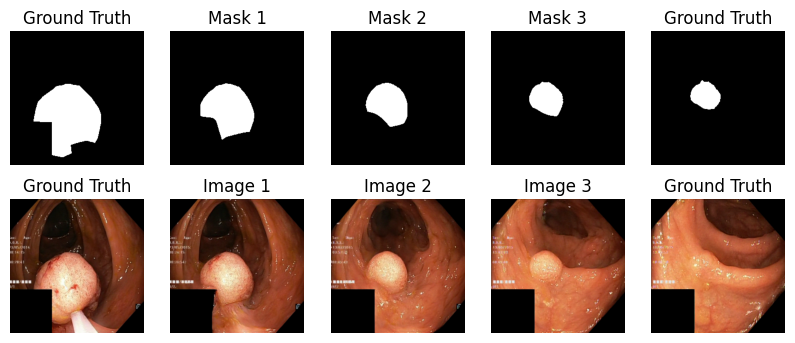

In [5]:
'Input'
interpol_step = 3
idx1 = 631 
idx2 = 573 
inference(idx1,idx2,interpol_step)

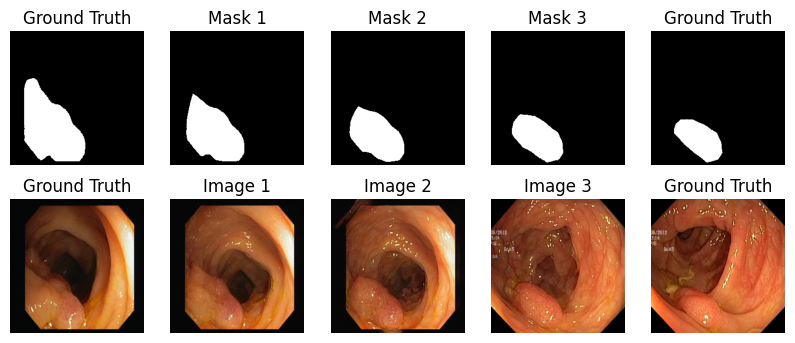

In [6]:
'Input'
interpol_step = 3 
idx1 = 6 
idx2 = 698 
inference(idx1,idx2,interpol_step)

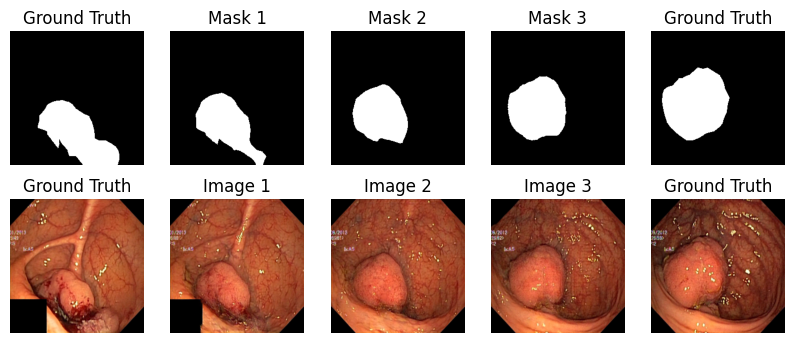

In [7]:
'Input'
interpol_step = 3 
idx1 = 1047 
idx2 = 1050
inference(idx1,idx2,interpol_step)

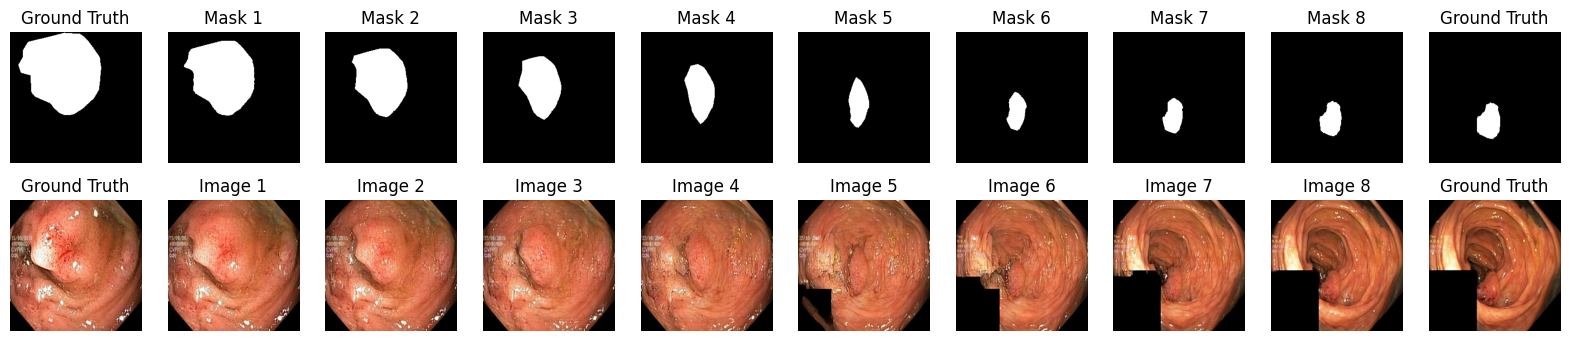

In [8]:
'Input'
interpol_step = 8 
idx1 = 551 
idx2 = 557
inference(idx1,idx2,interpol_step)

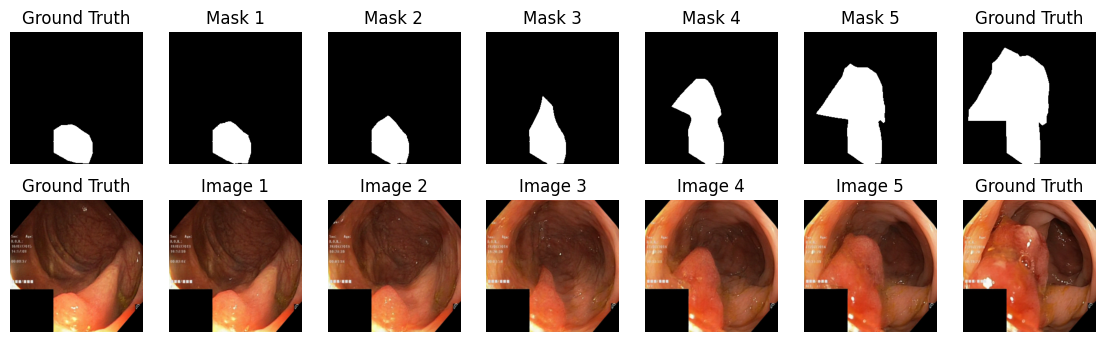

In [9]:
'Input'
interpol_step = 5 
idx1 = 643 
idx2 = 640
inference(idx1,idx2,interpol_step)

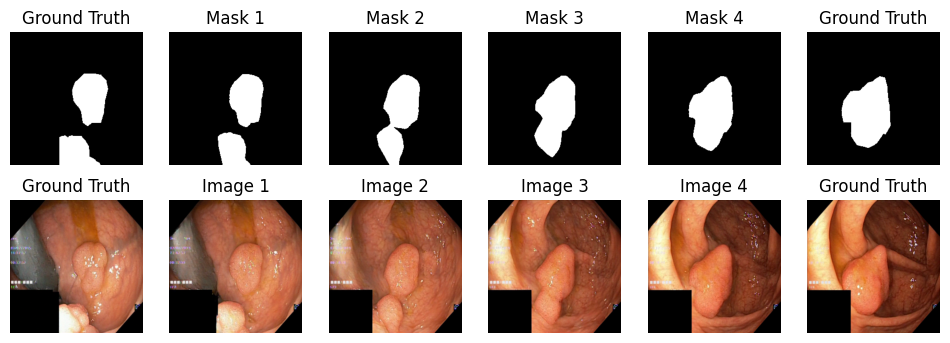

In [10]:
'Input'
interpol_step = 4 
idx1 = 684 
idx2 = 673
inference(idx1,idx2,interpol_step)

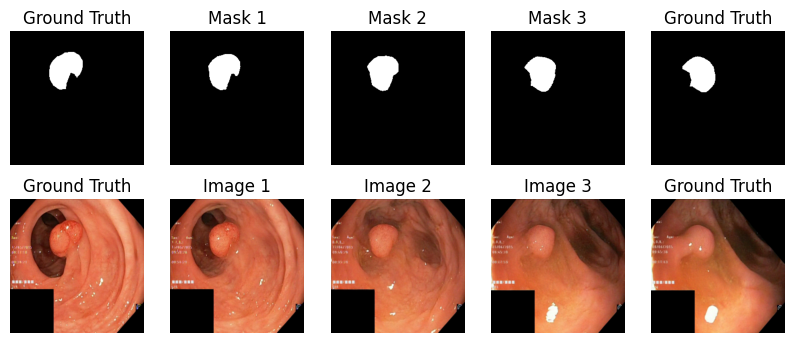

In [11]:
'Input'
interpol_step = 3 
idx1 = 563
idx2 = 564
inference(idx1,idx2,interpol_step)